In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from io import BytesIO
from rdkit.Chem import Draw
from sklearn import manifold
import matplotlib.pyplot as plt
from scipy.spatial import distance
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.preprocessing import StandardScaler
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.core.display import SVG, HTML

# Scaffolds

In [ ]:
def mol2display_png(mol):
    """Format RDKit mol for direct inline display. The most convenient, probably."""
    d2d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    buffer = BytesIO(d2d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [3]:
df = pd.read_csv('VEGF2.csv')
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]

In [8]:
df["scaffold1"] = df['mol'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaffold2"] = df['scaffold1'].apply(MurckoScaffold.MakeScaffoldGeneric)
df["scaffold3"] = df['scaffold2'].apply(MurckoScaffold.GetScaffoldForMol)
df["scaffold3_smiles"] = df['scaffold3'].apply(Chem.MolToSmiles)

In [35]:
df2 = df[['mol','scaffold3','scaffold3_smiles','value']]

In [38]:
df2 = df2.sort_values(by=['value'], ascending=False)
df2 = df2.drop_duplicates(subset=['scaffold3_smiles'])
df2 = df2.reset_index(drop=True)
df2.head()

,mol,scaffold3,scaffold3_smiles,value
0,<rdkit.Chem.rdchem.Mol object at 0x000001F36B2...,<rdkit.Chem.rdchem.Mol object at 0x000001F37F4...,C1CCC(CCCC2CCC(C3CCCCC3)CC2)CC1,9.85
1,<rdkit.Chem.rdchem.Mol object at 0x000001F36B2...,<rdkit.Chem.rdchem.Mol object at 0x000001F37F4...,C1CCC(CCC2CCC3CC(CC4CCCCC4)CCC23)CC1,9.70
2,<rdkit.Chem.rdchem.Mol object at 0x000001F36B2...,<rdkit.Chem.rdchem.Mol object at 0x000001F37F4...,C1CCC(CCC2CCCC3CC(CC4CCCC5CCCCC54)CCC23)C1,9.70
3,<rdkit.Chem.rdchem.Mol object at 0x000001F36B2...,<rdkit.Chem.rdchem.Mol object at 0x000001F37F4...,C1CCC(CCCC2CCC(CC3CCCC4CCCCC43)CC2)CC1,9.70
4,<rdkit.Chem.rdchem.Mol object at 0x000001F36B2...,<rdkit.Chem.rdchem.Mol object at 0x000001F37F4...,C1CCC(CCC2CCCC3CC(CC4CCCC5CCCCC54)CCC23)CC1,9.70


,scaffold3,mol,value
0,,,9.85
1,,,9.70
2,,,9.70
3,,,9.70
4,,,9.70

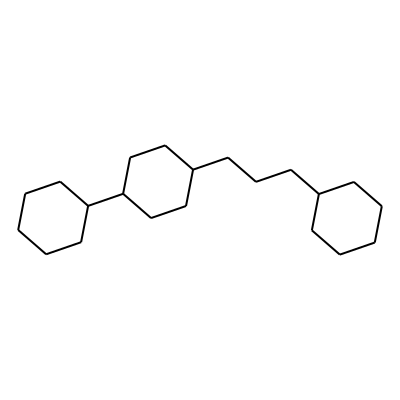
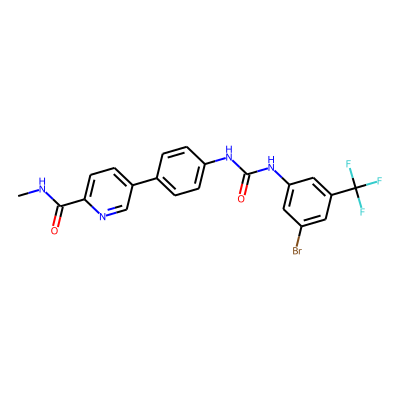
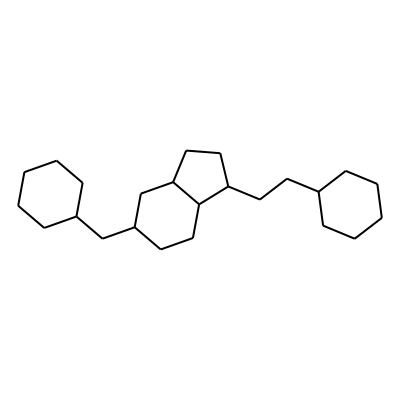
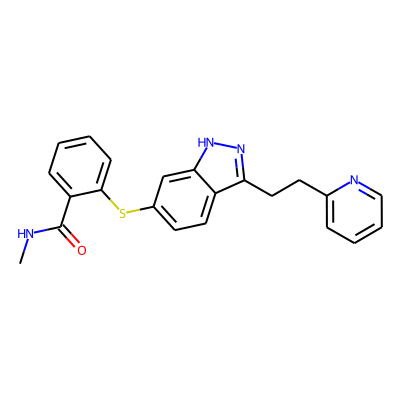
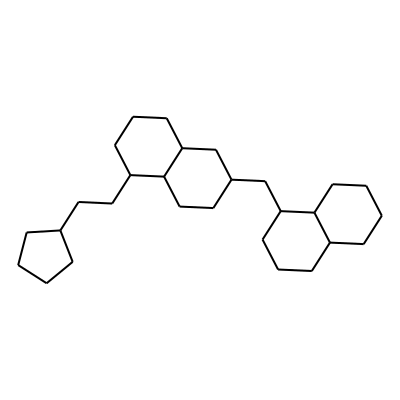
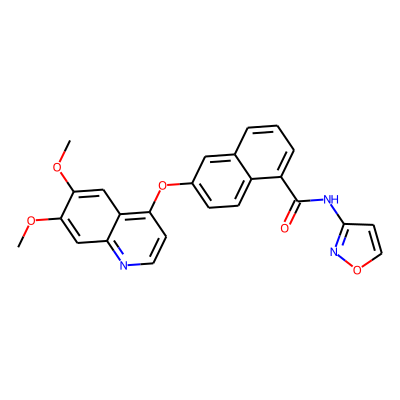
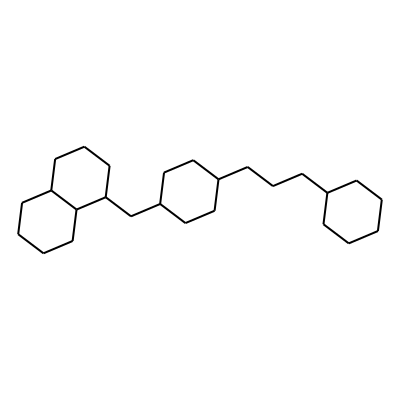
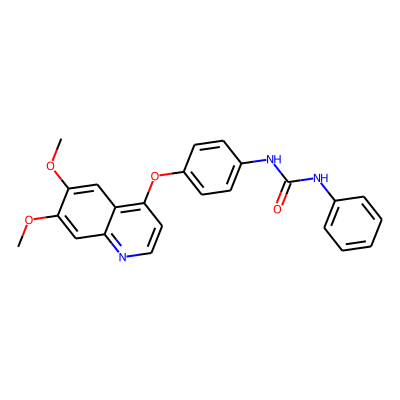
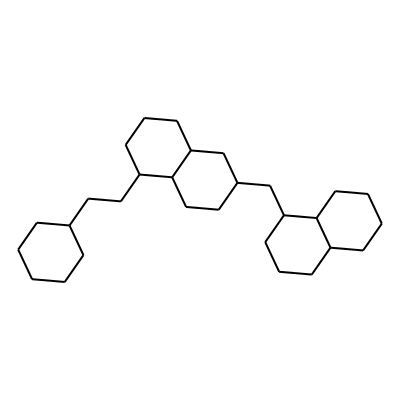
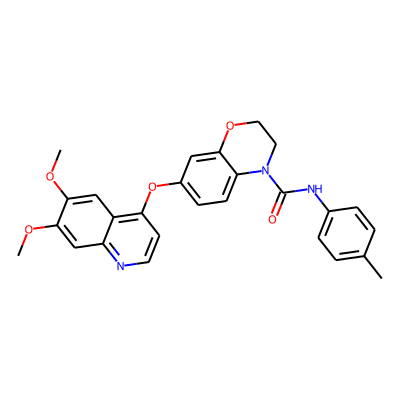

In [48]:
HTML(df2[['scaffold3','mol','value']].head().to_html(
    formatters={'mol': mol2display_png, 'scaffold3': mol2display_png}, escape=False))

# Shlukovací analýzy

In [80]:
from sklearn.cluster import KMeans
#from scipy.spatial import distance
#from sklearn import manifold
#from sklearn import decomposition
#from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from rdkit.Chem import rdMolDescriptors

In [ ]:
drug = Chem.SDMolSupplier('drugbank.sdf')
ids=[]
for i in range(len(drug)):
    if drug[i] is not None:
        ids.append(drug[i].GetProp('DATABASE_ID')) 
inchi=[]
for i in range(len(drug)):
    if drug[i] is not None:
        inchi.append(drug[i].GetProp('INCHI_IDENTIFIER')) 
data = {'id': ids,
        'inchi': inchi}
drug_df = pd.DataFrame(data, columns = ['id', 'inchi'])
drug_df['mol'] = [Chem.inchi.MolFromInchi(i) for i in drug_df['inchi']]
drug_df = drug_df.dropna()

### Fingerprints and TSNE

In [57]:
drug_finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in drug_df.mol]
finger = [Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in df.mol]
fingers = list(drug_finger) + list(finger)

In [66]:
m = list(drug_df.mol)+list(df.mol)
data = {'mol': m,
        'source': len(drug_df)*['drug'] + len(df)*['VEGF']}
d = pd.DataFrame(data, columns = ['mol', 'source'])

In [51]:
sparse = distance.pdist(list(finger), metric="jaccard")
distance = distance.squareform(sparse)

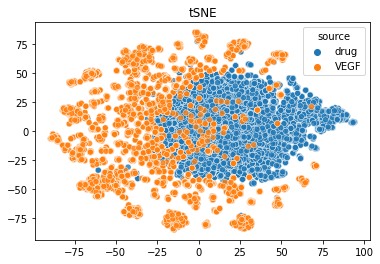

In [68]:
fps_tsne = TSNE(n_components=2, perplexity=50, init='random', learning_rate=200).fit_transform(fingers)
plot = sns.scatterplot(x=fps_tsne[:,0], y=fps_tsne[:,1], hue=d['source'], alpha=0.8).set_title('tSNE')

In [69]:
d['tsne_x']=fps_tsne[:,0]
d['tsne_y']=y=fps_tsne[:,1]

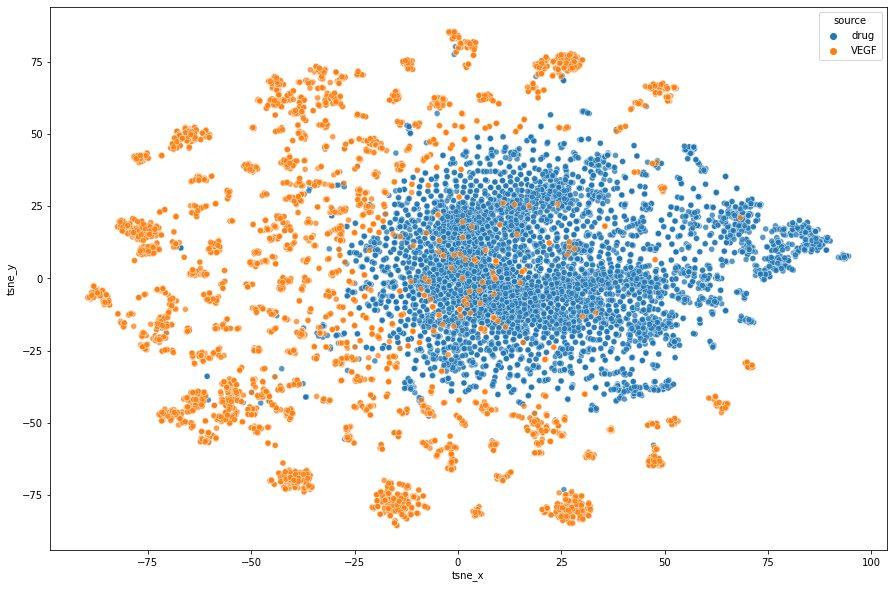

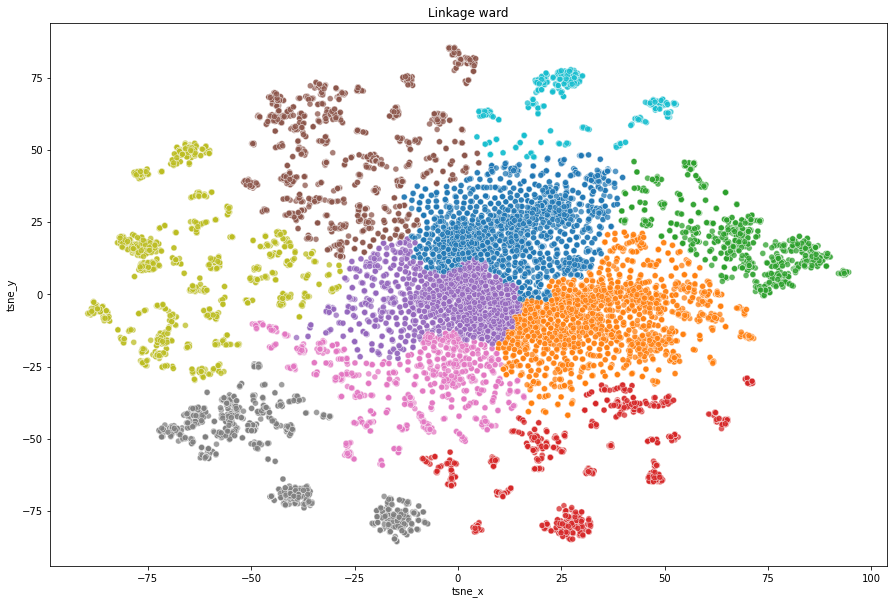

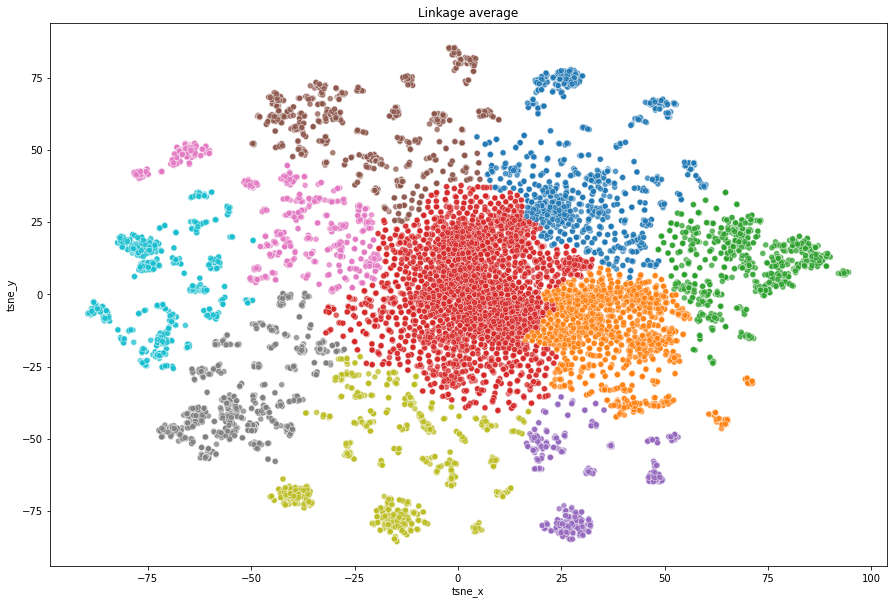

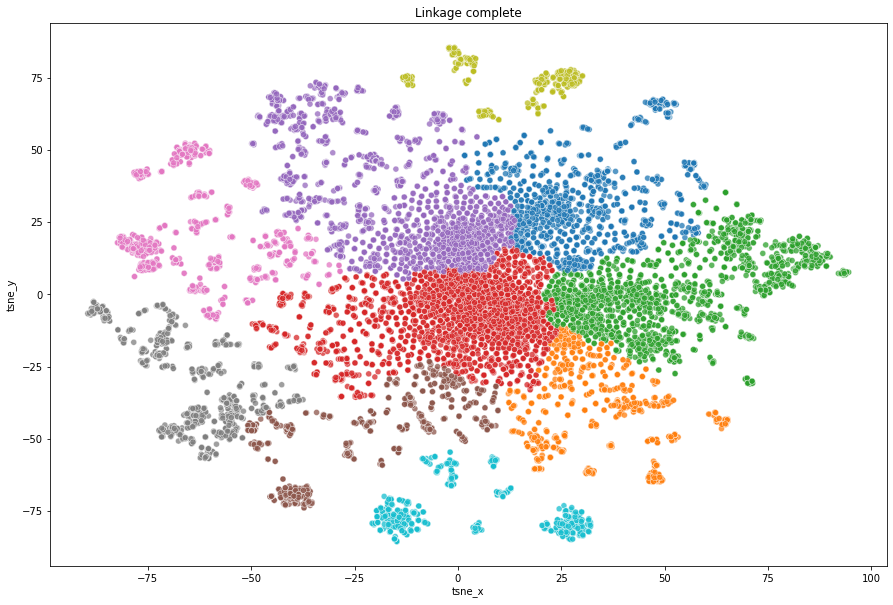

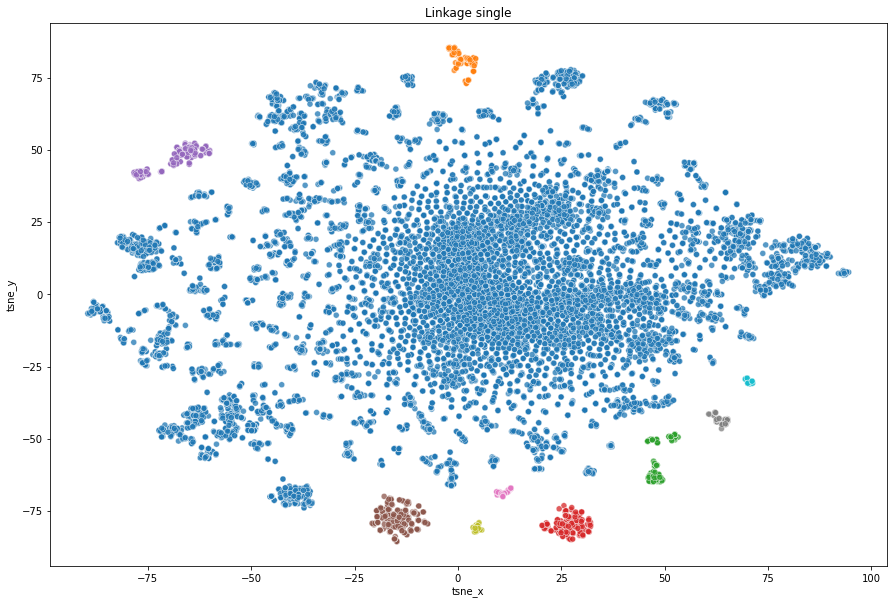

In [77]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x", y="tsne_y", data=d, hue="source", legend="brief", ax=ax, alpha=0.75)

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    clustering.fit(d[["tsne_x", "tsne_y"]])

    fig, ax = plt.subplots(figsize=(15,10))
    p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=d,
                      hue=[plt.cm.nipy_spectral(l / 10.) for l in clustering.labels_],
                      ax=ax,
                      alpha=0.75,
                      legend=False).set_title(f"Linkage {linkage}")

### MQN and PCA

In [81]:
MQNs = np.array([rdMolDescriptors.MQNs_(i) for i in drug_df.mol]+[rdMolDescriptors.MQNs_(i) for i in df.mol])
df_MQNs = pd.DataFrame(MQNs)
df_MQNs['source'] = d.source

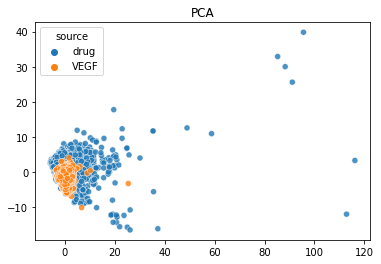

In [84]:
pca = PCA(n_components=0.9)
MQNs_2 = StandardScaler().fit_transform(MQNs)
PCA_com = pca.fit_transform(MQNs_2)
plot = sns.scatterplot(x=PCA_com[:,0], y=PCA_com[:,1], hue=df_MQNs['source'], alpha=0.8).set_title('PCA')

In [85]:
d['pca_x']=PCA_com[:,0]
d['pca_y']=PCA_com[:,1]

In [105]:
cluster_MQN = []

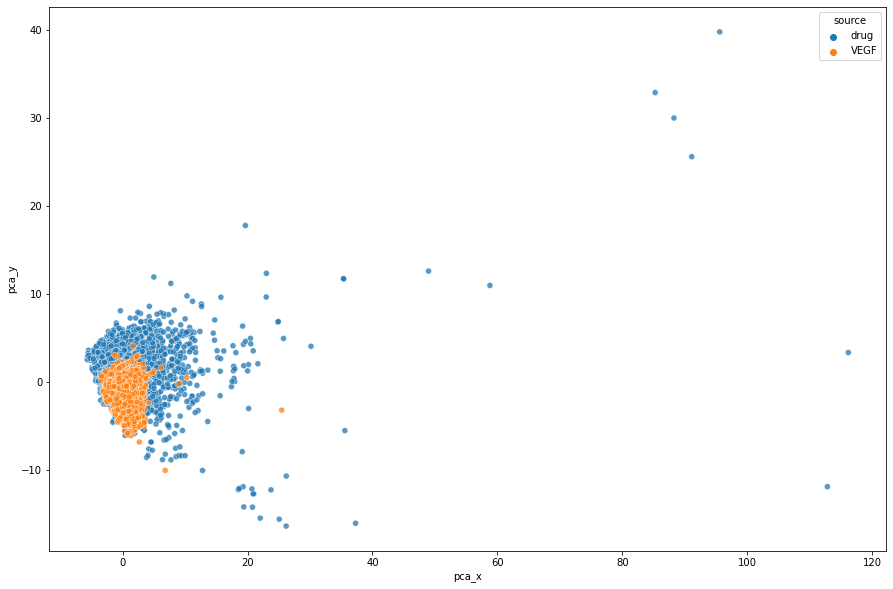

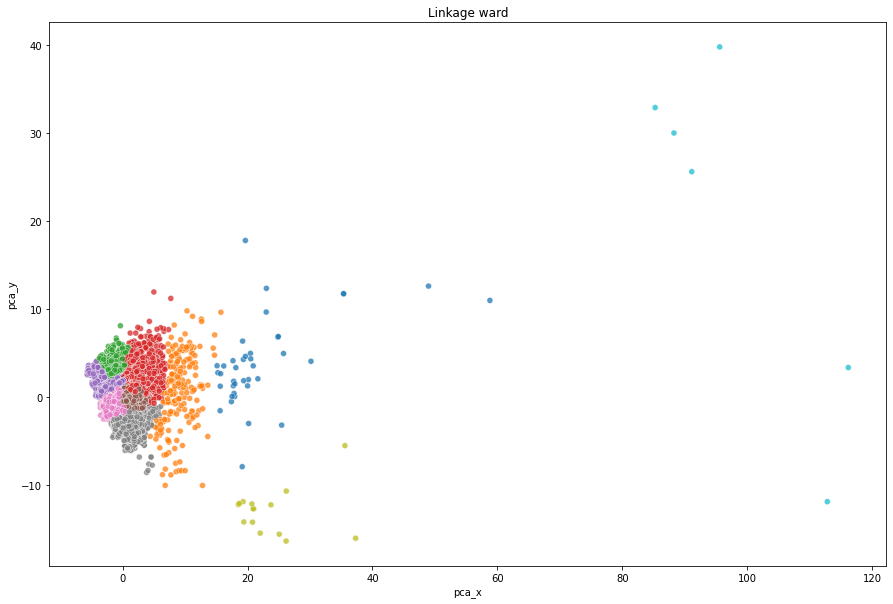

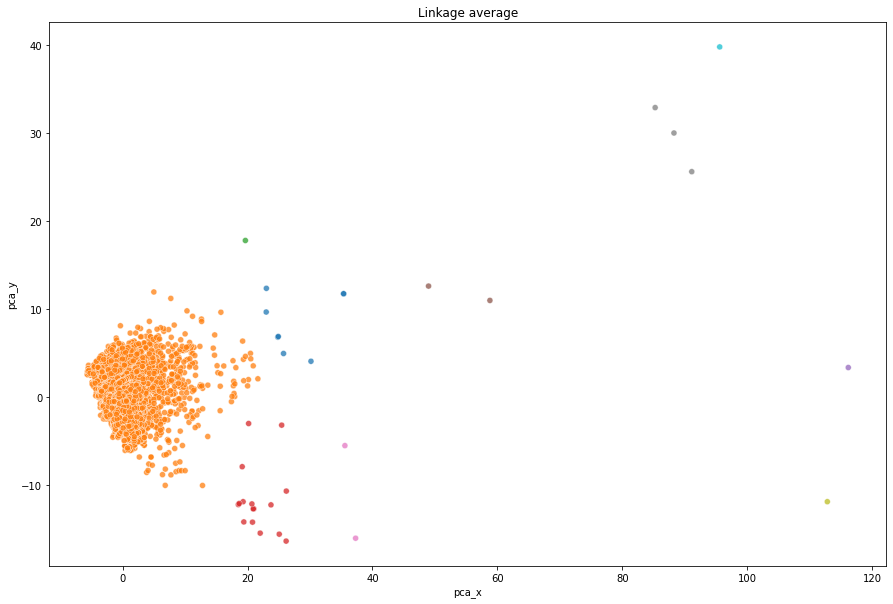

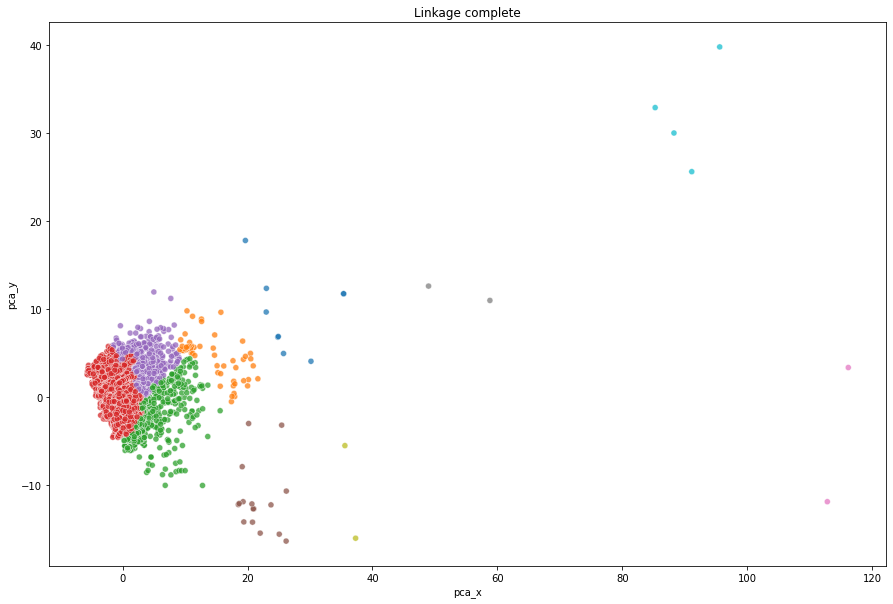

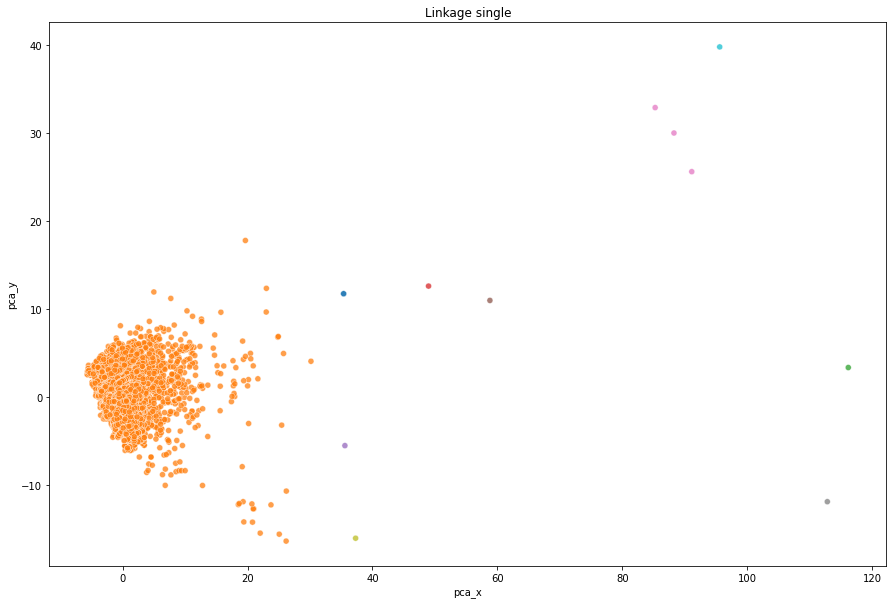

In [106]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="pca_x", y="pca_y", data=d, hue="source", legend="brief", ax=ax, alpha=0.75)

for linkage in ('ward', 'average', 'complete', 'single'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    clustering.fit(d[["pca_x", "pca_y"]])
    fig, ax = plt.subplots(figsize=(15,10))
    cluster_MQN.append(clustering.labels_)
    p=sns.scatterplot(x="pca_x",
                      y="pca_y",
                      data=d,
                      hue=[plt.cm.nipy_spectral(l / 10.) for l in clustering.labels_],
                      ax=ax,
                      alpha=0.75,
                      legend=False).set_title(f"Linkage {linkage}")

In [116]:
d['cluster_MQN'] = cluster_MQN[0]

In [117]:
c = d.loc[d['cluster_MQN'] == 0]
c['source'].value_counts()

drug    6
Name: source, dtype: int64

In [118]:
d[["cluster_MQN","source"]].groupby(["cluster_MQN","source"]).size()

cluster_MQN  source
0            drug         6
1            VEGF       232
             drug       946
2            VEGF         3
             drug       209
3            VEGF        73
             drug      1917
4            VEGF         1
             drug        38
5            VEGF      2409
             drug       406
6            VEGF      2265
             drug      1668
7            VEGF      1730
             drug       633
8            VEGF         2
             drug      1274
9            drug        15
dtype: int64